In [2]:
import pandas as pd
import sys, os
from IPython.display import display, Markdown
import numpy as np
import csv
import string 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn



In [ ]:
dataset = pd.read_csv('BBC News Train.csv')
test_set = pd.read_csv("BBC News Test.csv")

In [3]:
display(Markdown('**Executive summary for the test dataset**'))
data_test.info(show_counts=True)

display(Markdown('<br> **Executive summary for the training dataset**'))
data_train.info(show_counts=True)
### 1.3- Reviewing the head of the datasets

**Executive summary for the test dataset**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 765 to 773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  447 non-null    int64 
 1   Text       447 non-null    object
 2   Category   447 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.0+ KB


<br> **Executive summary for the training dataset**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 1265 to 794
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1043 non-null   int64 
 1   Text       1043 non-null   object
 2   Category   1043 non-null   object
dtypes: int64(1), object(2)
memory usage: 32.6+ KB


In [4]:
display(Markdown('**head for the test dataset**'))
print(data_test.head(5))
### 3 -- More verification for empty strings
display(Markdown('<br> **head for the training  dataset**'))
print(data_train.head(5))

**head for the test dataset**

      ArticleId                                               Text  \
765        1415  doves soar to uk album summit manchester rock ...   
100        1259  honda wins china copyright ruling japan s hond...   
441        2076  google to scan famous libraries the libraries ...   
367         151  greek sprinters suspended by iaaf greek sprint...   
1100        135  dollar hovers around record lows the us dollar...   

           Category  
765   entertainment  
100        business  
441            tech  
367           sport  
1100       business  


<br> **head for the training  dataset**

      ArticleId                                               Text  \
1265        182  blogger grounded by her airline a us airline a...   
392        1348  mps tout lords replacement plan a group of mps...   
117        1133  profits jump at china s top bank industrial an...   
1191       1900  potter director signs warner deal harry potter...   
471        1713  mps demand  budget leak  answers ministers hav...   

           Category  
1265           tech  
392        politics  
117        business  
1191  entertainment  
471        politics  


In [5]:
display(Markdown('**Further data verification: test dataset**'))
print("Checking for empty strings, number empty string: %s" % len(np.where(data_train.applymap(lambda x: x == ''))[1]),
      "\nChecking for unique values %s and total value are %s "%  (len(pd.unique(data_test["ArticleId"])), data_test.shape[0]))


display(Markdown('**Further data verification: training dataset**'))
print("Checking for empty strings, number empty string: %s" % len(np.where(data_train.applymap(lambda x: x == ''))[1]),
      "\nChecking for unique values %s and total value are %s "%  (len(pd.unique(data_test["ArticleId"])), data_train.shape[0]))


**Further data verification: test dataset**

Checking for empty strings, number empty string: 0 
Checking for unique values 447 and total value are 447 


**Further data verification: training dataset**

Checking for empty strings, number empty string: 0 
Checking for unique values 447 and total value are 1043 


In [8]:
class Text_classifier:
    def __init__(self, 
                 data, 
                 number_samples = 2000, 
                 number_features = 1000, 
                 number_categories = 5, 
                 number_top_words = 20, 
                 solver='cd', 
                 betaloss ='frobenius'): 
        self.data = data 
        self.numb_features = number_features
        self.numb_categories = number_categories
        self.numb_topwords = number_top_words
        self.solver = solver
        self.betaloss = betaloss
        self.max_df = 0.95
        self.min_df = 2
        self.init = "nndsvda"
        self.stop_words = "english"
        self.term_frequecy_idf = None # term frequency-inverse document frequency
        self.non_negative_MF_model = None
        self.transformed_data = None
        self.title = "Articles classification based on Frobenius norm"
        self.text_vectorizer = TfidfVectorizer(
                                max_df= self.max_df, 
                                min_df= self.min_df, 
                                #strip_accents= 'unicode',
                                max_features= self.numb_features, 
                                stop_words="english"
                                )
        
    def transform_matrix(self, ):
        self.term_frequecy_idf = self.text_vectorizer.fit_transform(self.data)
    
    def factorize_data(self, ):
        self.non_negative_MF_model = NMF(
                                n_components=self.numb_categories,
                                random_state=1,
                                solver = self.solver,
                                init=self.init,
                                beta_loss=self.betaloss,
                                alpha_W=0.00005,
                                alpha_H=0.00005,
                                l1_ratio=1,
                                ).fit(self.term_frequecy_idf)
    
    def get_feature_names(self, ): 
         self.feature_names = self.text_vectorizer.get_feature_names_out()
            
    def fit(self, ):
        self.transform_matrix()
        self.factorize_data()
        self.get_feature_names()
    
    def predict(self, X = None):
        if X is None:
            transformed_data = self.non_negative_MF_model.transform(self.term_frequecy_idf)
        else:
            transformed_data = self.non_negative_MF_model.transform(self.text_vectorizer.transform(X))
        
        self.transformed_data = [np.where(x == np.amax(x))[0][0] for x in transformed_data]
    
    def compute_confusion_m(self, y_true):
        cf_matrix = confusion_matrix(y_true, self.transformed_data)
        overall_ac = sum(np.diagonal(cf_matrix))/len(y_true)
        
        return cf_matrix, overall_ac 
        
    def plot_top_words(self, ):    
        fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
        axes = axes.flatten()
        top_features_data = []
        for topic_idx, topic in enumerate(self.non_negative_MF_model.components_):
            top_features_ind = topic.argsort()[: -self.numb_topwords - 1 : -1]
            top_features = [self.feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            top_features_data.append(top_features)
            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(self.title, fontsize=40)
        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
        plt.show()
        return top_features_data

def print_acurracy_measures(topic_lut, data_series_category, model):
    array_train_dataClass = [ topic_lut[x] for x in data_series_category]
    cf_matrix, accuracy = model.compute_confusion_m(array_train_dataClass)

    display(Markdown('**Accuracy**'))
    print("accuracy(train_data): %s" % round(accuracy*100,1))

    display(Markdown('**presenting confusion matrix**'))
    df_cf_matrix = pd.DataFrame(cf_matrix, index = [i for i in topic_lut.keys()],
                      columns = [i for i in topic_lut.keys()])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cf_matrix, annot=True)

unsupervised_text_class = Text_classifier(data_train['review'], number_features=1490)

unsupervised_text_class.fit()

unsupervised_text_class.predict()

### 2.2 getting the order of the categories
<ol> to find out which category order is set in the factorized matrix, we plot the top 20. With a quick look, we can see that the order is sport, politics, tech, entertainment, business. Then, we proceed to create a dictionary that keep these categories.

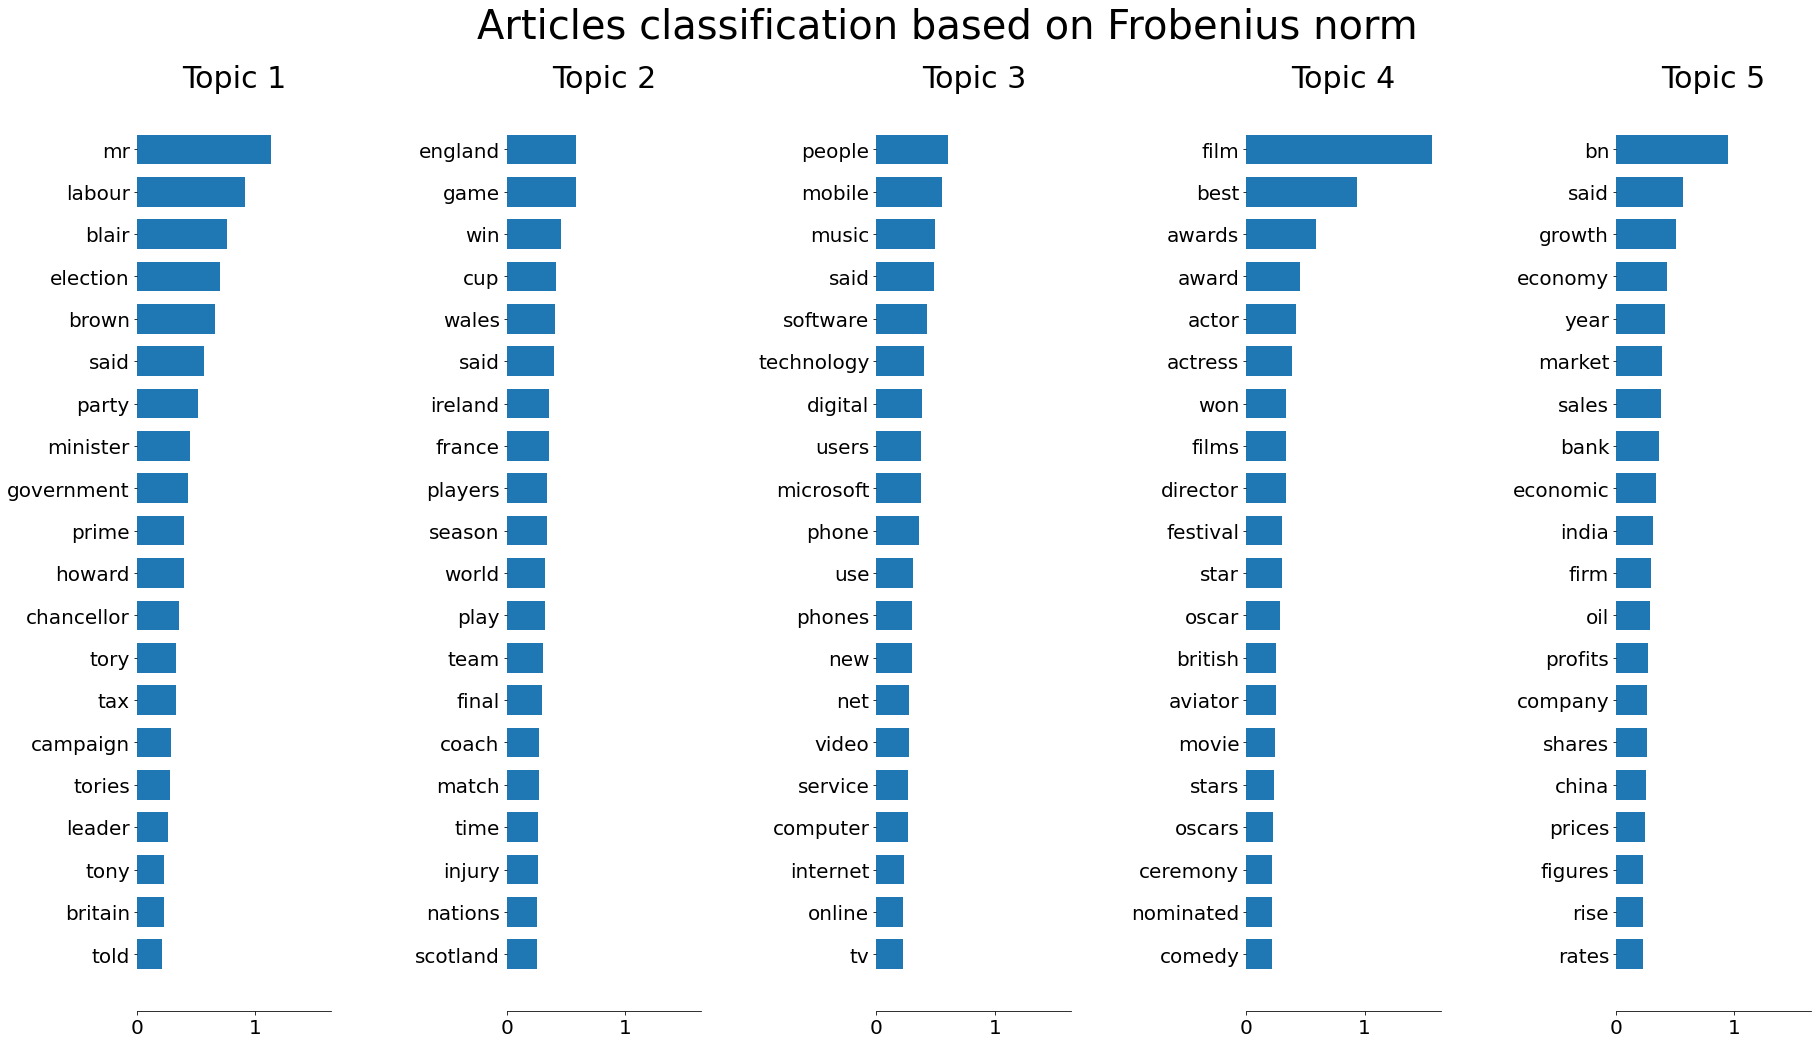

In [9]:
top_features_data = unsupervised_text_class.plot_top_words()

### 2.3 Printing accuracy measures
In the first matrix visualization, I show the confusion matrix computed with the same data that the model was trained. Further down, I show the matrix accuracy for the test data.

{'politics': 0, 'sport': 1, 'tech': 2, 'entertainment': 3, 'business': 4}


**Accuracy**

accuracy(train_data): 86.9


**presenting confusion matrix**

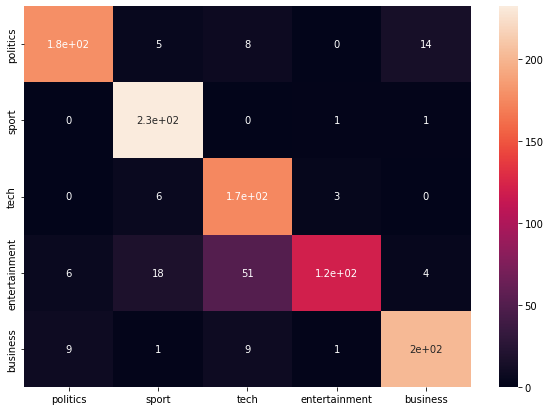

In [10]:
# This step is a trick for ordering the result of the matrix factorization because it give differents order of the components
#everytime you run it.
# This step is manual, so it requires that you see the top words and classified the groups quickly

top_words = {"politics" : ['mr', 'labour', 'blair', 'election', 'said', 'party', 'brown', 'government', 'howard', 'minister', 'prime', 'tory', 'tax', 'chancellor', 'campaign'],
             "sport" : ['game', 'england', 'win', 'said', 'ireland', 'france', 'wales', 'players', 'play', 'cup', 'chelsea', 'team', 'season', 'coach', 'match'], 
             "tech" : ['music', 'people', 'mobile', 'said', 'phone', 'technology', 'users', 'digital', 'broadband', 'net', 'software', 'new', 'use', 'video', 'uk'],
             "entertainment" : ['film', 'best', 'awards', 'actor', 'award', 'films', 'won', 'oscar', 'actress', 'star', 'comedy', 'director', 'aviator', 'movie', 'festival', 'oscars'],
             "business": ['bn', 'said', 'growth', 'economy', 'year', 'oil', 'market', 'shares', 'firm', 'bank', 'sales', 'prices', 'company', 'economic', 'china', 'dollar', 'rise']
             }
index = 0
topic_lut = {}

for top_features in top_features_data:
    if (len(set(top_words["politics"]) & set(top_features))) > 10:
        topic_lut["politics"] = index
    elif (len(set(top_words["sport"]) & set(top_features))) > 10:
        topic_lut["sport"] = index
    elif (len(set(top_words["business"]) & set(top_features))) > 10:
        topic_lut["business"] = index
    elif (len(set(top_words["entertainment"]) & set(top_features))) > 10:
        topic_lut["entertainment"] = index
    elif (len(set(top_words["tech"]) & set(top_features))) > 10:
        topic_lut["tech"] = index
    index +=1
            

print(topic_lut)
print_acurracy_measures(topic_lut, data_train["Category"], unsupervised_text_class)


**Accuracy**

accuracy(train_data): 89.0


**presenting confusion matrix**

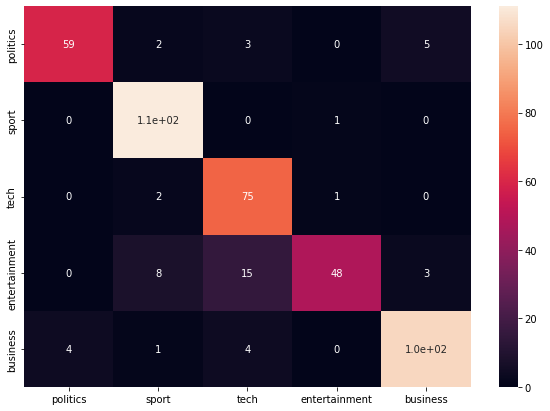

In [11]:
######## working with test data #####
data_test['review'] = format_text(data_test['Text'])
unsupervised_text_class.predict(data_test['review'])
print_acurracy_measures(topic_lut, data_test["Category"], unsupervised_text_class)
